## Pd5 Jamroży Bartosz

In [15]:
library(tidyverse)
library(reshape2)


library(DALEX)
library(DALEXtra)
library('randomForest')


options(warn=-1)

Dane z: https://www.kaggle.com/camnugent/california-housing-prices

## Model
przykładowy model z : https://www.kaggle.com/camnugent/introduction-to-machine-learning-in-r-tutorial

In [24]:
housing = read.csv("housing.csv")

# clean data
housing$total_bedrooms[is.na(housing$total_bedrooms)] = median(housing$total_bedrooms , na.rm = TRUE)

#Fix the total columns - make them means
housing$mean_bedrooms = housing$total_bedrooms/housing$households
housing$mean_rooms = housing$total_rooms/housing$households

drops = c('total_bedrooms', 'total_rooms')
housing = housing[ , !(names(housing) %in% drops)]

#Turn categoricals into booleans
categories = unique(housing$ocean_proximity)

#split the categories off
cat_housing = data.frame(ocean_proximity = housing$ocean_proximity)

for(cat in categories){
  cat_housing[,cat] = rep(0, times= nrow(cat_housing))
}


for(i in 1:length(cat_housing$ocean_proximity)){
  cat = as.character(cat_housing$ocean_proximity[i])
  cat_housing[,cat][i] = 1
}

cat_columns = names(cat_housing)
keep_columns = cat_columns[cat_columns != 'ocean_proximity']
cat_housing = select(cat_housing,one_of(keep_columns))

#Scale the numerical variables

drops = c('ocean_proximity','median_house_value')
#housing_num =  housing[ , !(names(housing) %in% drops)]

#scaled_housing_num = scale(housing_num)

#Merge the altered numerical and categorical dataframes
# cleaned_housing = cbind(cat_housing, scaled_housing_num, median_house_value=housing$median_house_value)


# Create a test set of data
cleaned_housing<-housing

set.seed(1738) # Set a random seed so that same sample can be reproduced in future runs

sample = sample.int(n = nrow(cleaned_housing), size = floor(.8*nrow(cleaned_housing)), replace = F)
train = cleaned_housing[sample, ] #just the samples
test  = cleaned_housing[-sample, ] #everything but the samples

#Random forest model
library('randomForest')

set.seed(1738)

train_y = train[,'median_house_value']
train_x = train[, names(train) !='median_house_value']

rf_model = randomForest(train_x, y = train_y , ntree = 500, importance = TRUE)

In [25]:
explainer <- DALEX::explain(model = rf_model, data=train_x, y=train_y)

Preparation of a new explainer is initiated
  -> model label       :  randomForest  (  default  )
  -> data              :  16512  rows  9  cols 
  -> target variable   :  16512  values 
  -> predict function  :  yhat.randomForest  will be used (  default  )
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package randomForest , ver. 4.6.14 , task regression (  default  ) 
  -> predicted values  :  numerical, min =  41241.04 , mean =  206772.5 , max =  499881.8  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -131935.9 , mean =  -258.1369 , max =  181414.8  
  A new explainer has been created!  


In [26]:
colnames(train_x)

[1] "longitude"          "latitude"           "housing_median_age"
[4] "population"         "households"         "median_income"     
[7] "ocean_proximity"    "mean_bedrooms"      "mean_rooms"

### Partial Dependence Profiles

In [37]:
pdp_median_income_1<- model_profile(explainer, variables = "median_income",groups="ocean_proximity")

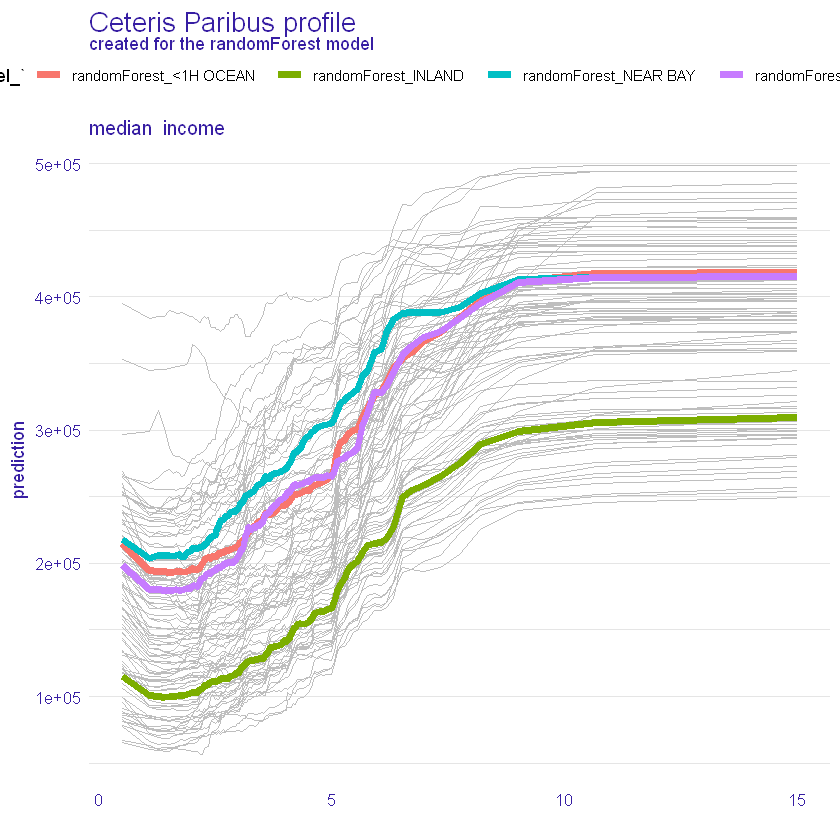

In [38]:
plot(pdp_median_income_1,geom = "profiles")

W poprzednich pracach domowych zmienna median income lokalnie miała największe znaczenie na predykcje. A także w przypadku była globalnie najważniejsza dla analizy Feature Importance.
Jak widać na profilu  pdp  większy dochód mieszkańców oznacza większą cenę nieruchomości. Zależność zachodzi niezależnie od położenia nieruchomości względem oceanu.


In [41]:
pdp_longitude_1<- model_profile(explainer, variables = "longitude",groups="ocean_proximity")

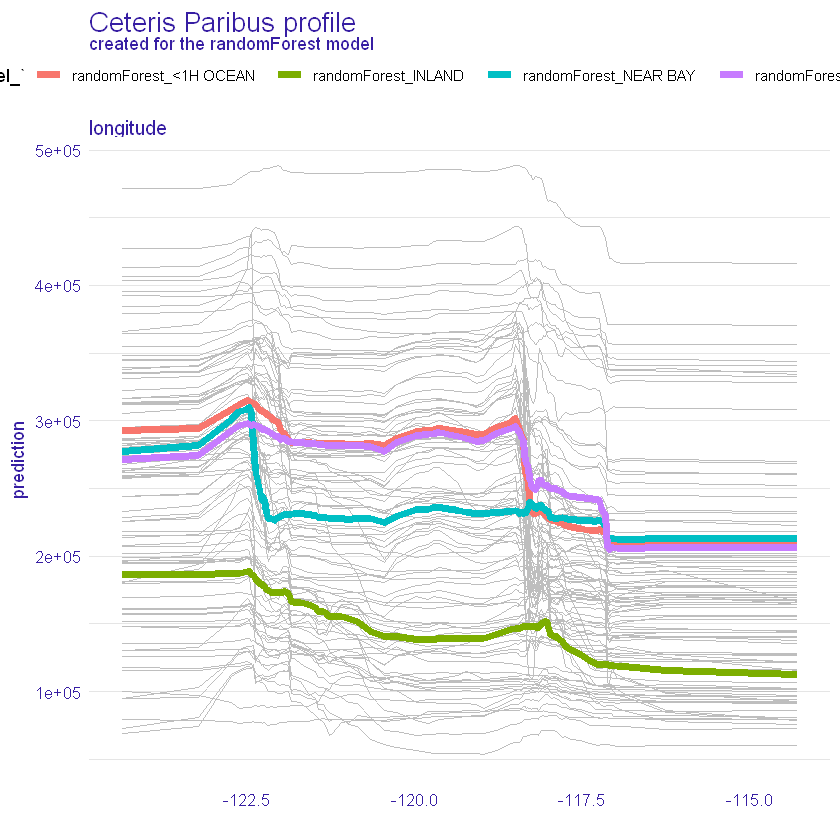

In [42]:
plot(pdp_longitude_1,geom = "profiles")

In [45]:
pdp_latitude_1<- model_profile(explainer, variables = "latitude",groups="ocean_proximity")

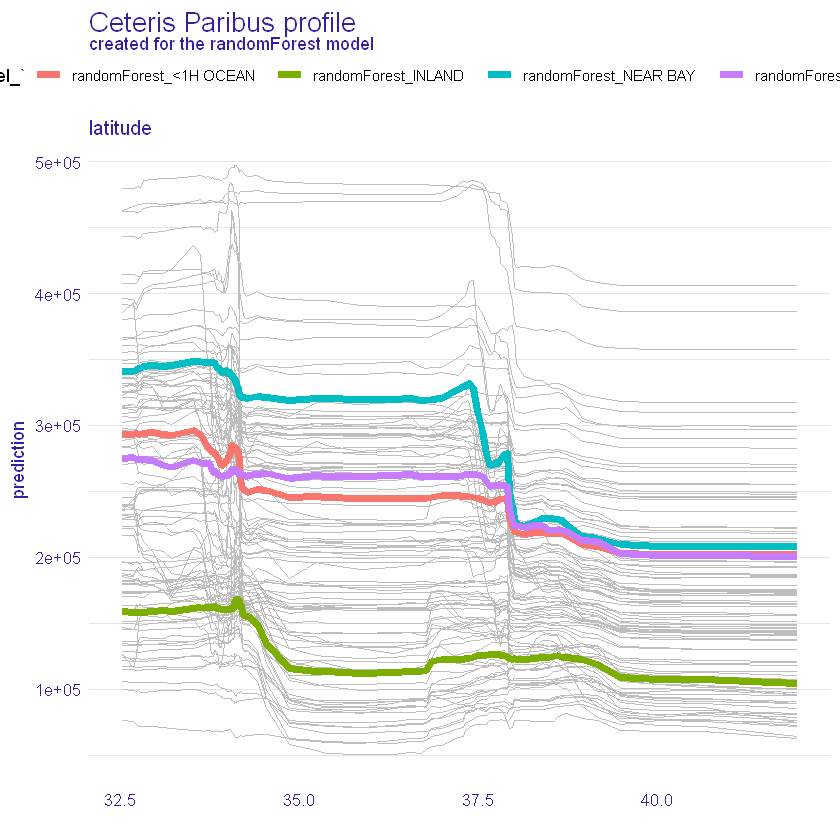

In [46]:
plot(pdp_latitude_1,geom = "profiles")

Dla zmiennych geograficznych (szerokość i długość geograficzna), zachodzi podoba obserwacja, tzn im nieruchomość leży bardziej na północny zachód tym jest droższy. Jednak w przypadku tych ziemnych występują lokalne odstępstwa od tej reguły, widać to na szarych jednostkowych profilach, które miejscami maja piki, niezgodne ze średnimi (kolorowymi) profilami.

### Accumulated Local Dependence & Partial Dependence Profiles

In [62]:
ale_population <- model_profile(explainer, type = "accumulated")
ale_population$agr_profiles$`_label_` <- "ale"
pdp_population<- model_profile(explainer)
pdp_population$agr_profiles$`_label_` <- "pdp"

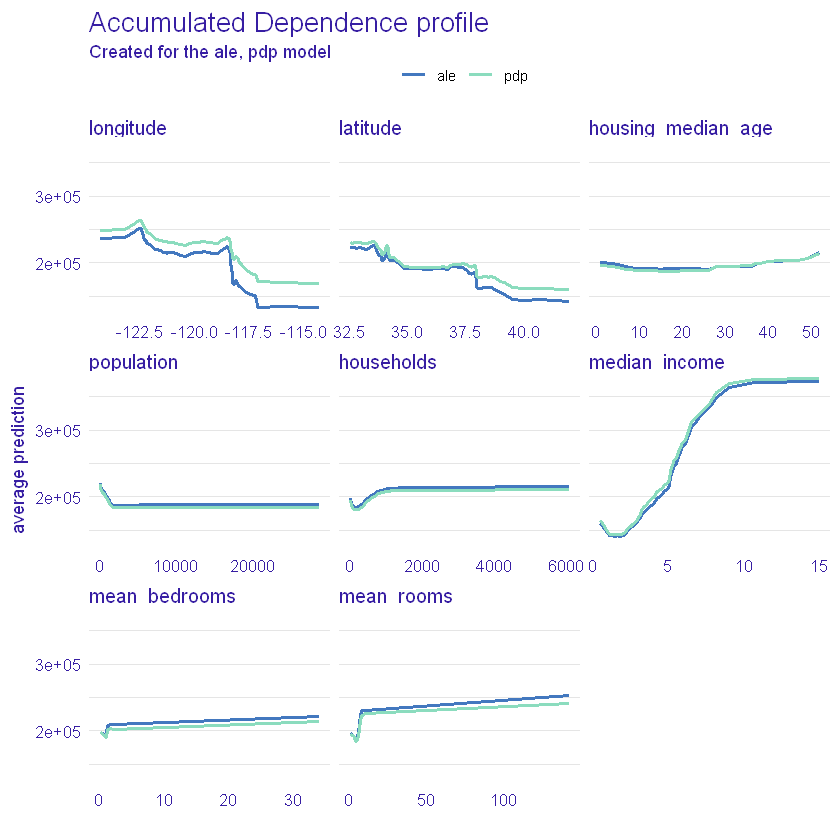

In [63]:
plot(ale_population,pdp_population)

ALE i PDP:  oba profile są mocno zbliżone w przypadku każdej numerycznej obserwacji w zbiorze projektowym. Oba Profile pokazują te same trendy . Największe odstępstwa widać dla zmiennych geograficznych, PDP bardziej „dyskryminuje” południowo wschodnie nieruchomości. 

### Grid

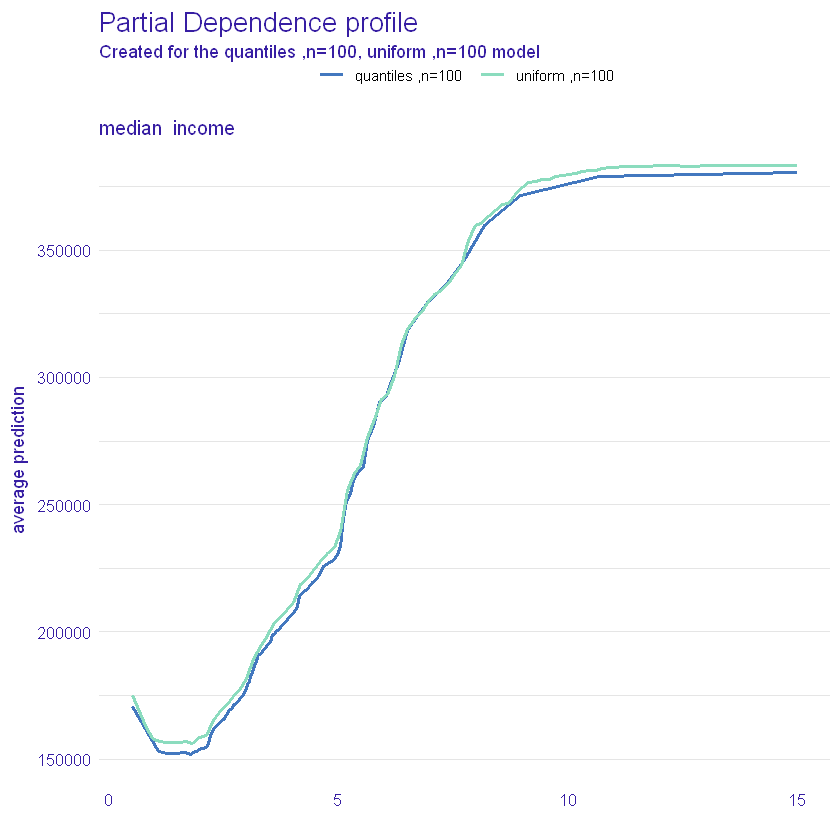

In [80]:
pdp_grid_1 <- model_profile(explainer, variables = "median_income", N = 1000, grid_points = 100,variable_splits_type = "quantiles")
pdp_grid_2 <- model_profile(explainer, variables = "median_income", N = 1000, grid_points = 100, variable_splits_type = "uniform")
pdp_grid_1$agr_profiles$`_label_` <- "quantiles ,n=100"
pdp_grid_2$agr_profiles$`_label_` <- "uniform ,n=100"
plot(pdp_grid_1,pdp_grid_2)

Dla dużej liczby próbek, n=100, różnice między jednostajnym wybieraniem punktów a kwantowym jest niewielka, większe różniące występować będą przy mniejszym n 

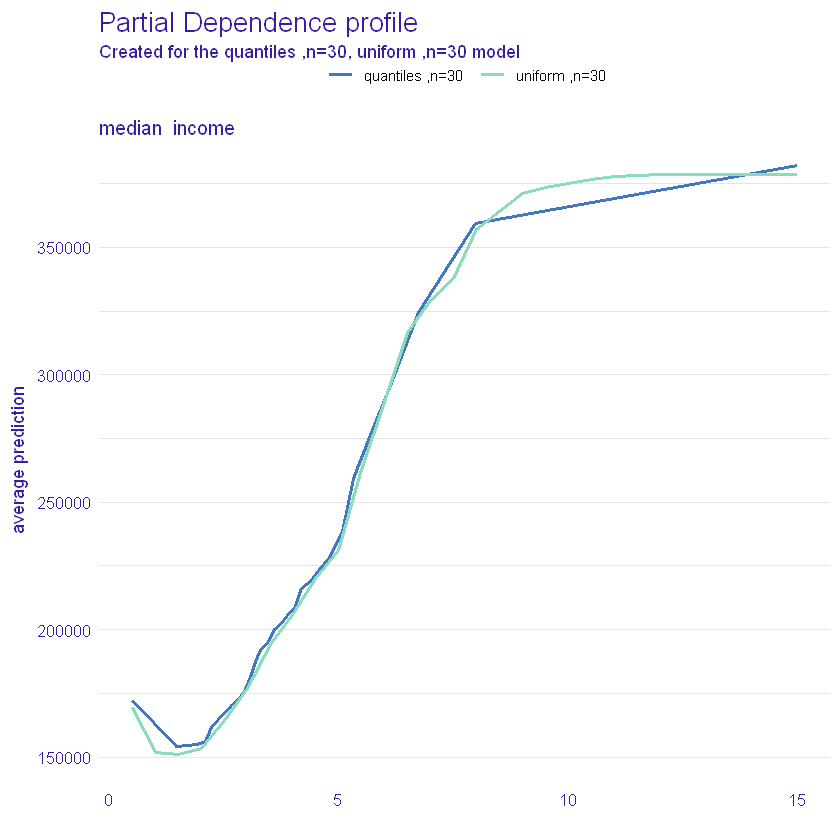

In [81]:
pdp_grid_1 <- model_profile(explainer, variables = "median_income", N = 1000, grid_points = 30,variable_splits_type = "quantiles")
pdp_grid_2 <- model_profile(explainer, variables = "median_income", N = 1000, grid_points = 30, variable_splits_type = "uniform")
pdp_grid_1$agr_profiles$`_label_` <- "quantiles ,n=30"
pdp_grid_2$agr_profiles$`_label_` <- "uniform ,n=30"
plot(pdp_grid_1,pdp_grid_2)

Teraz dla  n=30, największy równica występuje dla dużych dochodów, jest to ogon o stosunkowo małym zagęszczeniu danych dlatego tez profil tworzony pry pomocy kwartyli stworzy tam mniej punktów a co za tym idzie bardziej kanciasty wykres.

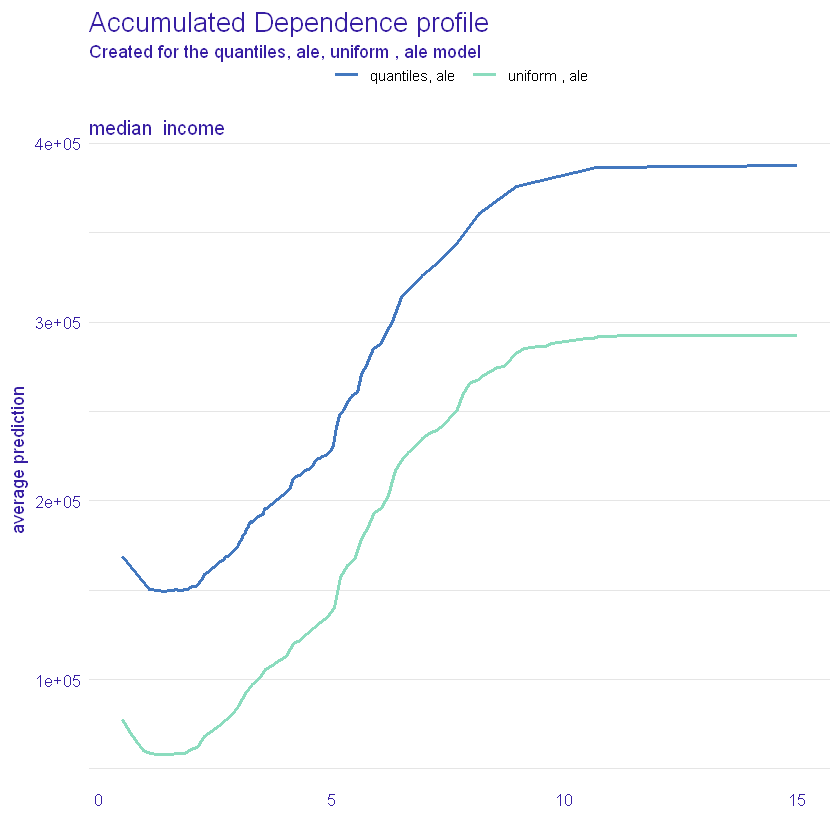

In [86]:
ale_grid_1 <- model_profile(explainer, variables = "median_income",type = "accumulated", N = 1000, grid_points = 100)
ale_grid_2 <- model_profile(explainer, variables = "median_income",type = "accumulated", N = 1000, grid_points = 100, variable_splits_type = "uniform")
ale_grid_1$agr_profiles$`_label_` <- "quantiles, ale"
ale_grid_2$agr_profiles$`_label_` <- "uniform , ale"
plot(ale_grid_1,ale_grid_2)

W  przypadku profilu ALE dzieje się coś dziwnego. Mamy znacząca różnica miedzy wybieraniem punktów jednostajnie a za pomocą kwartyli.